<a href="https://colab.research.google.com/github/raphaelp-silva/GNN_Pytorch_geometric/blob/main/GNN_esquizofrenia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [144]:
pip install torch_geometric

In [145]:
import torch
import numpy as np
import kagglehub
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data, DataLoader
from sklearn.neighbors import kneighbors_graph
from sklearn.model_selection import train_test_split

In [146]:
# Base de dados disponivel em: https://www.kaggle.com/datasets/asinow/schizohealth-dataset?resource=download

base = pd.read_csv('/content/schizophrenia_dataset.csv')

In [147]:
np.random.seed(123)
torch.manual_seed(123)

In [148]:
base.head()

,Hasta_ID,Yaş,Cinsiyet,Eğitim_Seviyesi,Medeni_Durum,Meslek,Gelir_Düzeyi,Yaşadığı_Yer,Tanı,Hastalık_Süresi,Hastaneye_Yatış_Sayısı,Ailede_Şizofreni_Öyküsü,Madde_Kullanımı,İntihar_Girişimi,Pozitif_Semptom_Skoru,Negatif_Semptom_Skoru,GAF_Skoru,Sosyal_Destek,Stres_Faktörleri,İlaç_Uyumu
0,1,72,1,4,2,0,2,1,0,0,0,0,0,0,32,48,72,0,2,2
1,2,49,1,5,2,2,1,0,1,35,1,1,1,1,51,63,40,2,2,0
2,3,53,1,5,3,2,1,0,1,32,0,1,0,0,72,85,51,0,1,1
3,4,67,1,3,2,0,2,0,0,0,0,0,1,0,10,21,74,1,1,2
4,5,54,0,1,2,0,2,1,0,0,0,0,0,0,4,27,98,0,1,0


In [149]:
# Renomeando as colunas:
base.columns = ['ID_paciente', 'Idade', 'Gênero', 'Nivel_educ', 'Estado_civ', 'Profissao', 'Nivel_renda', 'Area_habitacao', 'Diagnostico', 'Duração_doença', 'N_hospitalizacao', 'Hist_familiar', 'Uso_subst', 'Temperamento_suic', 'Score_sintomas_positivos', 'Score_sintomas_negativos', 'GAF_score', 'Suporte_social', 'Fator_estresse', 'Adesao_medicação']

In [150]:
base.head()

,ID_paciente,Idade,Gênero,Nivel_educ,Estado_civ,Profissao,Nivel_renda,Area_habitacao,Diagnostico,Duração_doença,N_hospitalizacao,Hist_familiar,Uso_subst,Temperamento_suic,Score_sintomas_positivos,Score_sintomas_negativos,GAF_score,Suporte_social,Fator_estresse,Adesao_medicação
0,1,72,1,4,2,0,2,1,0,0,0,0,0,0,32,48,72,0,2,2
1,2,49,1,5,2,2,1,0,1,35,1,1,1,1,51,63,40,2,2,0
2,3,53,1,5,3,2,1,0,1,32,0,1,0,0,72,85,51,0,1,1
3,4,67,1,3,2,0,2,0,0,0,0,0,1,0,10,21,74,1,1,2
4,5,54,0,1,2,0,2,1,0,0,0,0,0,0,4,27,98,0,1,0


In [151]:
base.shape

(10000, 20)

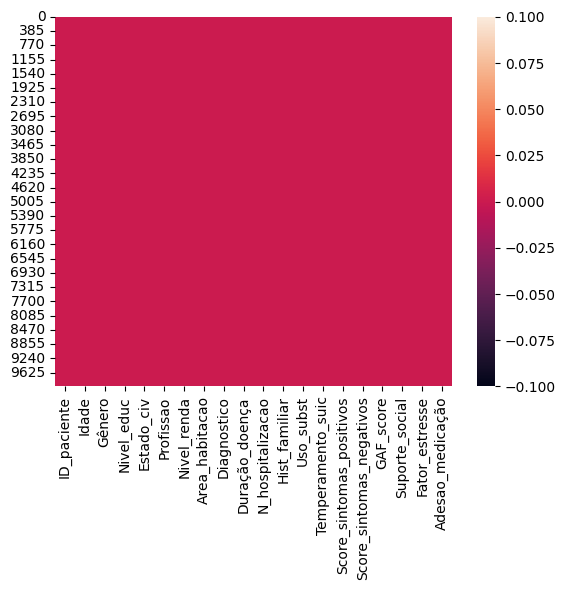

In [152]:
# verificando se existe valores nulos na base:
sns.heatmap(base.isnull());

In [153]:
# retirando colunas com menor relevância em nossa análise:

base = base.drop('Nivel_educ', axis = 1)
base = base.drop('Estado_civ', axis = 1)
base = base.drop('Profissao', axis = 1)
base = base.drop('Nivel_renda', axis = 1)
base = base.drop('Area_habitacao', axis = 1)
base = base.drop('ID_paciente', axis = 1)


In [154]:
base.head()

,Idade,Gênero,Diagnostico,Duração_doença,N_hospitalizacao,Hist_familiar,Uso_subst,Temperamento_suic,Score_sintomas_positivos,Score_sintomas_negativos,GAF_score,Suporte_social,Fator_estresse,Adesao_medicação
0,72,1,0,0,0,0,0,0,32,48,72,0,2,2
1,49,1,1,35,1,1,1,1,51,63,40,2,2,0
2,53,1,1,32,0,1,0,0,72,85,51,0,1,1
3,67,1,0,0,0,0,1,0,10,21,74,1,1,2
4,54,0,0,0,0,0,0,0,4,27,98,0,1,0


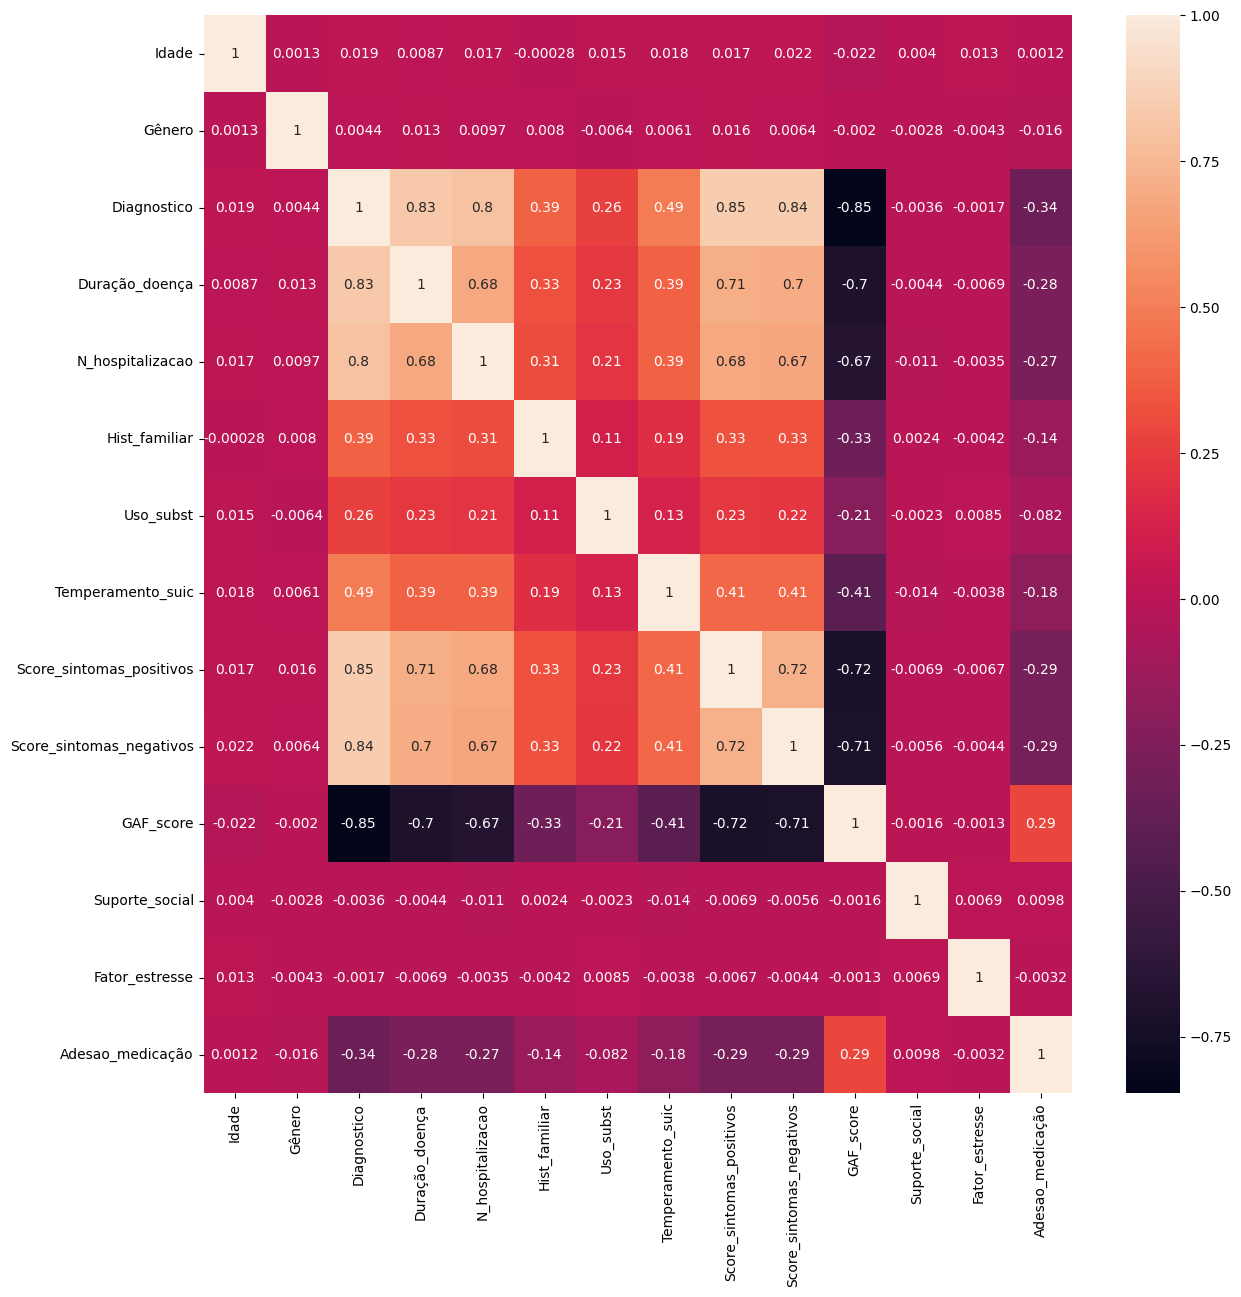

In [155]:
f, ax = plt.subplots(figsize=(14, 14))
sns.heatmap(base.corr(), annot = True);

In [156]:
previsores = base.iloc[:, [0,1,3,4,5,6,7,8,9,10,11,12,13]].values
classe = base.iloc[:, 2].values

In [157]:
previsores = torch.tensor(previsores, dtype = torch.float) # x, matriz de features
classe = torch.tensor(classe, dtype = torch.long) # y, rótulo dos nós

knn_graph = kneighbors_graph(previsores, 10, mode = 'connectivity') # gerando a matriz de vizinhos mais próximos em formato esparso.
non_zero_indices = knn_graph.nonzero() # retornando os indices não nulos de uma matriz esparsa.
edge_index = torch.tensor(np.array(knn_graph.nonzero()), dtype=torch.long) # convertendo para o tensor esparso no fomato 2,num_edges.

# Dividindo os dados em treino e teste:
X_train, X_test, y_train, y_test = train_test_split(previsores, classe, test_size=0.2, random_state=42, stratify = classe)

# Função para gerar um novo edge_index para cada conjunto (train/test):
def generate_edge_index(features):
    knn_graph = kneighbors_graph(features.numpy(), 10, mode='connectivity')
    edge_index = torch.tensor(np.array(knn_graph.nonzero()), dtype=torch.long)
    return edge_index

# Gerando um novo edge_index para cada conjunto
edge_index_train = generate_edge_index(X_train)
edge_index_test = generate_edge_index(X_test)

# Criando o Data para treino e teste
train_data = Data(x=X_train, edge_index=edge_index_train, y=y_train)
test_data = Data(x=X_test, edge_index=edge_index_test, y=y_test)

train_loader = DataLoader([train_data], batch_size=1, shuffle=True)
test_loader = DataLoader([test_data], batch_size=1, shuffle=False)

/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [158]:
print(data)

Data(x=[10000, 13], edge_index=[10000, 10000], y=[10000])


In [159]:
# Criando a rede:
class GNN(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim, output_dim):
    super(GNN, self).__init__()
    self.conv1 = GCNConv(input_dim, hidden_dim)
    self.conv2 = GCNConv(hidden_dim, output_dim)

  def forward(self, data):
    x, edge_index = data.x, data.edge_index
    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = self.conv2(x, edge_index)
    return F.log_softmax(x, dim=1)

#criando o modelo:
input_dim = previsores.shape[1]
hidden_dim = 32
output_dim = 2

model = GNN(input_dim, hidden_dim, output_dim)

In [160]:
# definindo otimizador e função de perda:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
loss_fn = torch.nn.NLLLoss()

# função de treino:
def train():
  model.train()
  total_loss = 0
  for batch in train_loader:
    optimizer.zero_grad()
    out = model(batch)
    loss = loss_fn(out, batch.y)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
    return total_loss / len(train_loader)

for epoch in range (100):
  loss = train()
  if epoch % 10 == 0 :
    print(f'época {epoch}, Loss: {loss:.4f}')

época 0, Loss: 19.2406
época 10, Loss: 0.0040
época 20, Loss: 0.0932
época 30, Loss: 0.0057
época 40, Loss: 0.0000
época 50, Loss: 0.0000
época 60, Loss: 0.0000
época 70, Loss: 0.0000
época 80, Loss: 0.0000
época 90, Loss: 0.0000


In [161]:
model.eval()

GNN(
  (conv1): GCNConv(13, 32)
  (conv2): GCNConv(32, 2)
)

In [162]:
with torch.no_grad():
  predictions = model(data).argmax(dim=1)
  print(predictions[:10])

tensor([0, 1, 1, 0, 0, 0, 0, 1, 0, 1])


/usr/local/lib/python3.11/dist-packages/torch_geometric/utils/_spmm.py:66: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "


In [163]:
def test(model, test_loader):
    model.eval()  # Coloca o modelo em modo de avaliação
    correct = 0
    total = 0

    with torch.no_grad():  # Não precisa calcular gradientes
        for batch in test_loader:
            out = model(batch)  # Faz a predição
            pred = out.argmax(dim=1)  # Obtém a classe predita (maior probabilidade)
            correct += (pred == batch.y).sum().item()  # Conta acertos
            total += batch.y.size(0)  # Conta total de exemplos

    accuracy = correct / total  # Calcula acurácia
    return accuracy

# Chamando a função de teste
accuracy = test(model, test_loader)
print(f"Acurácia do modelo nos dados de teste: {accuracy:.4f}")

Acurácia do modelo nos dados de teste: 1.0000


Época 0, Loss: 0.0000, Acurácia: 1.0000
Época 10, Loss: 0.0000, Acurácia: 1.0000
Época 20, Loss: 0.0000, Acurácia: 1.0000
Época 30, Loss: 0.0000, Acurácia: 1.0000
Época 40, Loss: 0.0000, Acurácia: 1.0000
Época 50, Loss: 0.0000, Acurácia: 1.0000
Época 60, Loss: 0.0000, Acurácia: 1.0000
Época 70, Loss: 0.0000, Acurácia: 1.0000
Época 80, Loss: 0.0000, Acurácia: 1.0000
Época 90, Loss: 0.0000, Acurácia: 1.0000


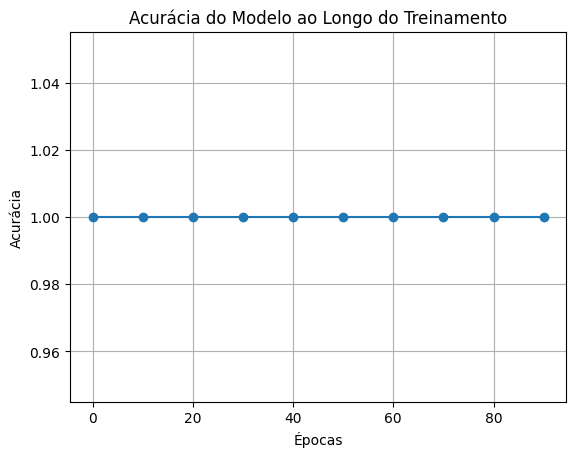

In [164]:
accuracy_history = []

# Testando o modelo em cada época
for epoch in range(100):
    loss = train()
    if epoch % 10 == 0:
        accuracy = test(model, test_loader)
        accuracy_history.append(accuracy)
        print(f'Época {epoch}, Loss: {loss:.4f}, Acurácia: {accuracy:.4f}')

# Criando o gráfico de acurácia
plt.plot(range(0, 100, 10), accuracy_history, marker='o', linestyle='-')
plt.xlabel("Épocas")
plt.ylabel("Acurácia")
plt.title("Acurácia do Modelo ao Longo do Treinamento")
plt.grid()
plt.show()

In [165]:
model.eval()
with torch.no_grad():
    total = 0
    correct = 0
    for batch in test_loader:
        out = model(batch)
        pred = out.argmax(dim=1)
        total += batch.y.size(0)
        correct += (pred == batch.y).sum().item()

    test_accuracy = correct / total
    print(f"Acurácia no Teste Final: {test_accuracy:.4f}")


Acurácia no Teste Final: 1.0000
